# Semi-supervision and domain adaptation with AdaMatch
### 使用AdaMatch统一半监督与（无监督）域适应

原文链接：https://keras.io/examples/vision/adamatch/

## Note:
这个博客实际上做的是通过 **MNIST** 数据集训练模型，然后让模型能够应用到 **SHVN** 数据集上，后者数据集特点是单个样本内容由随机个数、随机颜色的数字图像组成，而 MNIST 数据集单个样本均为一个数字并且是单通道的图像。  

总体来说，这个博客上的东西非常值得学习，从博客中可以明显感觉出他有仔细阅读过原文。但整个博主好像是印度裔，导致他的英文有些晦涩，如果遇到了阅读困难或者存在歧义的地方，最好去阅论文[原文](https://arxiv.org/abs/2106.04732)，因为我遇到的几处歧义点也是通过阅读原文解决的。

-------------

## Introduction
In this example, we will implement the AdaMatch algorithm, proposed in [AdaMatch: A Unified Approach to Semi-Supervised Learning and Domain Adaptation](https://arxiv.org/abs/2106.04732) by Berthelot et al. It sets a new state-of-the-art in unsupervised domain adaptation (as of June 2021). AdaMatch is particularly interesting because it unifies semi-supervised learning (SSL) and unsupervised domain adaptation (UDA) under one framework. It thereby provides a way to perform semi-supervised domain adaptation (SSDA).  

在这个例子中实现了 AdaMatch 算法，该算法由 **Berthelot** 等人发表的文章 [AdaMatch: A Unified Approach to Semi-Supervised Learning and Domain Adaptation](https://arxiv.org/abs/2106.04732) 中被提出。截至2021年6月前都是最先进的（SOTA）无监督域适应技术。AdaMatch将半监督学习（SSL）和无监督域适应（UDA）统一在一个模型中，因此提供了一种半监督域适应（SSDA）方法。  

【注】原始博客中的以下语句
```python
!pip install tf-models-official
```
这个语句会帮你自动下载最新的 Tensorflow CPU 版本和对应的 Keras 版本，可能会造成 GPU 版本没有被调用。所以在执行完上述语句后需要再执行以下语句将Keras版本替换回来，并且卸载掉他给你装上的 CPU 版本。
```python
!pip uninstall tensorflow
!pip install keras==2.6.0
```
如果你发现执行完上述语句中出现以下报错：  
**No module named 'tensorflow.python.keras.backend'**  
使用以下语句重新安装 GPU 版本的 Tensorflow  
```python
!pip uninstall tensorflow-gpu
!pip install tensorflow-gpu==2.6.0
```
后面需要用到 official 包中的 RandAugment 工具用于数据增强。

使用2.6.0这个版本，是因为这个是目前（2022年2月3日）最新的[通过测试的构建](https://tensorflow.google.cn/install/source#gpu)，我个人也使用这个版本完整测试了该仓库中所有的代码。常用GPU几个版本可以通过上面的链接知晓，也可以通过下标查询。  

|版本|Python版本|编译器|构建工具|cuDNN|CUDA|
|----|----|---|---|---|---|
|2.6.0|3.6~3.9|GCC 7.3.1|Bazel 3.7.2|8.1|11.2|
|2.4.0|3.6~3.8|GCC 7.3.1|Bazel 3.1.0|8.0|11.0|
|2.2.0|3.5~3.8|GCC 7.3.1|Bazel 2.0.0|7.6|10.1|
|2.0.0|2.7、3.3~3.7|GCC 7.3.1|Bazel 0.26.1|7.4|10.0|
|1.14.0|2.7、3.3~3.7|GCC 4.8|Bazel 0.24.1|7.4|10.0|

尽管Google提供了众多通过测试的版本，但如果能用最新的还是尽可能使用最新的版本，这不仅是因为新版本使用的 CUDA 更现金，还因为新版本增加了很多前沿的工具包，如在 2.6.0 中就有多头注意力层 **MultiHeadAttention** 可以直接拿来使用，省去了重复造轮子的步骤。

------------

## Preliminaries
In semi-supervised learning (SSL), we use a small amount of labeled data to train models on a bigger unlabeled dataset. Popular semi-supervised learning methods for computer vision include  [FixMatch](https://arxiv.org/abs/2001.07685), [MixMatch](https://arxiv.org/abs/1905.02249), [Noisy Student Training](https://arxiv.org/abs/1911.04252), etc. You can refer to this example to get an idea of what a standard SSL workflow looks like.  

在半监督学习（SSL）中，用少量标记的数据在大量未标记的数据上进行训练。在CV领域中比较流行的半监督方法有 [FixMatch](https://arxiv.org/abs/2001.07685)，[MixMatch](https://arxiv.org/abs/1905.02249)，[Noisy Student Training](https://arxiv.org/abs/1911.04252)等，可以参考 Keras 中 [这个例子](https://keras.io/examples/vision/adamatch/) 来了解基本的半监督学习（SSL）流程是怎样的。  

In unsupervised domain adaptation, we have access to a source labeled dataset and a target unlabeled dataset. Then the task is to learn a model that can generalize well to the target dataset. The source and the target datasets vary in terms of distribution. The following figure provides an illustration of this idea. In the present example, we use the MNIST dataset as the source dataset, while the target dataset is SVHN, which consists of images of house numbers. Both datasets have various varying factors in terms of texture, viewpoint, appearence, etc.: their domains, or distributions, are different from one another.  

在无监督域适应中，我们可以使用有标签的源数据和无标签的目标数据。任务是训练一个能够很好泛化到目标数据集上的模型。源数据和目标数据在分布上存在不同，下图展示了两者之间的差异。在当前案例中，使用 **MNIST** 作为源数据，**SVHN** 为目标数据，该数据是由门牌号组成，两个数据集图像在纹理、观察点（拍摄角度）、外观（字体和颜色）等方面都存在不同，即两个数据集的域和分布不同。

<img src="../images/CV_Img/dJFSJuT.png">

Popular domain adaptation algorithms in deep learning include [Deep CORAL](https://arxiv.org/abs/1612.01939), [Moment Matching](https://arxiv.org/abs/1812.01754), etc.  
在深度学习中的域适应算法有 [Deep CORAL](https://arxiv.org/abs/1612.01939) 和 [Moment Matching](https://arxiv.org/abs/1812.01754) 等。

知乎上的博主 **小蚂蚁曹凯** 在他的文章 [《迁移学习》: 领域自适应(Domain Adaptation)的理论分析](https://zhuanlan.zhihu.com/p/50710267) 上对域适应（**Domain Adaptation**）做出了通俗易懂的解释：  
```python
Domain Adaptation基本思想是既然源域和目标域数据分布不一样，那么就把数据都映射到一个特征空间中，在特征空间中找一个度量准则，使得源域和目标域数据的特征分布尽量接近，于是基于源域数据特征训练的判别器，就可以用到目标域数据上。
```
尽管这个博客是从生成对抗网络角度出发进行解释的，但我认为这是最容易让人理解的阐述。

-------------

## Setup

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from official.vision.image_classification.augment import RandAugment

import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

------------

## Prepare the data

### MNIST

In [2]:
(
    (mnist_x_train, mnist_y_train),
    (mnist_x_test, mnist_y_test),
) = keras.datasets.mnist.load_data()

# 添加一个通道维度
mnist_x_train = tf.expand_dims(mnist_x_train, -1)
mnist_x_test = tf.expand_dims(mnist_x_test, -1)

# 对标签进行 one-hot 编码
mnist_y_train = tf.one_hot(mnist_y_train, 10).numpy()

### SVHN
这里使用了 **tensorflow-dataset** 这个库，这也是 Tensorflow 中诸多“开箱即用”的库之一。使用这个库下载好的数据会被存放到 “C:\Users\你的用户名\tensorflow_datasets\” 路径下，并且以后使用会直接加载本地硬盘。此外，这个工具最好的是它能直接返回 tf.data.Dataset 类型的数据。  

这个语句因为涉及到数据集划分，耗时可能会有些长，如果你发现你的 Generating 部分一直卡在 60% 附近请耐心等待，我的电脑初次运行该语句使用了 12 分钟，其中下载数据集使用了约 3 分钟，剩下的时间都是在生成数据集。

In [3]:
svhn_train, svhn_test = tfds.load(
    "svhn_cropped", split=["train", "test"], as_supervised=True
)

Dl Completed...: 100%|██████████| 3/3 [02:07<00:00, 42.38s/ url]


Dataset svhn_cropped downloaded and prepared to C:\Users\Lucks\tensorflow_datasets\svhn_cropped\3.0.0. Subsequent calls will reuse this data.


In [3]:
svhn_train, svhn_test = tfds.load(
    "svhn_cropped", split=["train", "test"], as_supervised=True
)

-------------

## Define constants and hyperparameters
### 设置常量及超参数

在 [原文](extension://bfdogplmndidlpjfhoijckpakkdjkkil/pdf/viewer.html?file=https%3A%2F%2Farxiv.org%2Fpdf%2F2106.04732.pdf) 的第3.2小节中，提到了关于超参数的设置，内容如下：  
```python
AdaMatch only requires the following two hyper-parameters: 
AdaMatch仅仅需要以下两个超参数
(1) Confidence threshold τ (set to 0.9 for all experiments). 
    置信阈值 τ (所有实验中都设置为0.9).
(2) Unlabeled target batch size ratio uratio (set to 3 for all experiments) which defines how much larger is the unlabeled batch.
    目标数据batch和源数据batch的大小比（所有实验中都设置为3）.
```
这是下段代码中 **TARGET_BATCH_SIZE = 3 * SOURCE_BATCH_SIZE** 的来源。

In [4]:
RESIZE_TO = 32

SOURCE_BATCH_SIZE = 64
TARGET_BATCH_SIZE = 3 * SOURCE_BATCH_SIZE  # Reference: Section 3.2
EPOCHS = 10
STEPS_PER_EPOCH = len(mnist_x_train) // SOURCE_BATCH_SIZE
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

AUTO = tf.data.AUTOTUNE
LEARNING_RATE = 0.03

WEIGHT_DECAY = 0.0005
INIT = "he_normal"
DEPTH = 28
WIDTH_MULT = 2

--------------

## Data augmentation utilities
A standard element of SSL algorithms is to feed weakly and strongly augmented versions of the same images to the learning model to make its predictions consistent. For strong augmentation, RandAugment is a standard choice. For weak augmentation, we will use horizontal flipping and random cropping.  

一个常规的 SSL 算法的步骤是将图像的弱增强和强增强数据送入模型，让模型在这两种增强数据上保持一致性。对于强增强而言 [RandAugment](https://arxiv.org/abs/1909.13719) 是常规手段。对于弱增强而言，使用水平翻转和随机剪裁足以。

博主 **Zerg_Wang** 在博客 [论文笔记：RandAugment](https://blog.csdn.net/Zerg_Wang/article/details/105030503) 中详细讨论了使用 RandAugment 对模型性能提升带来的好处。而 TensorFlow 提供的包中 RandAugment 需要的参数只有2个N和M，相比较于传统数据增强策略动辄几十重而言，RandAugment最大的特点在于“随机”和“强度”。  
其中“随机”是通过参数 N 控制的，即从多种增强手段中随机选取一种执行 N 次；  
而“强度”是用过参数 M 控制的，即控制每种随机变化的强度。

In [5]:
augmenter = RandAugment(num_layers=2, magnitude=5)

**tf.tile(input, multiples, name=None)** 维度复制  

* input: 输入的向量
* multipes: 每个维度需要复制的次数
* name: 操作的名，通常默认为 None 就行 

其中核心为 multipes 这个参数，在这个例子中的 [1, 1, 3] 意思是将第一个和第二个维度乘以1，第三个维度乘以3。
```python
example 1: 
a = np.random.rand(5, 5, 1)  # a.shape=(5, 5, 1)
b = tf.tile(a, [1, 1, 3])    # b.shape=(5, 5, 3)

example 2:
a = np.array([[1,2,3],[4,5,6]])
b = tf.tile(a, [2, 3])

a = array([[1, 2, 3],
           [4, 5, 6]])

b = array( [[1, 2, 3, 1, 2, 3, 1, 2, 3],
            [4, 5, 6, 4, 5, 6, 4, 5, 6],
            [1, 2, 3, 1, 2, 3, 1, 2, 3],
            [4, 5, 6, 4, 5, 6, 4, 5, 6]])
```
需要注意的是，这个函数只是将原有向量的内容进行了复制，并不是真正意义上的灰度转换。

In [6]:
def weak_augment(image, source=True):
    if image.dtype != tf.float32:
        image = tf.cast(image, tf.float32)

    # 如果是 MNIST 输入的话，首先将其从灰度图转为RGB。这里使用的是 tf.tile() 函数对内容复制
    if source:
        image = tf.image.resize_with_pad(image, RESIZE_TO, RESIZE_TO)  # 用零填充
        image = tf.tile(image, [1, 1, 3])
    image = tf.image.random_flip_left_right(image)  # 随机左右镜像
    image = tf.image.random_crop(image, (RESIZE_TO, RESIZE_TO, 3))  # 随机剪裁
    return image

In [7]:
def strong_augment(image, source=True):
    if image.dtype != tf.float32:
        image = tf.cast(image, tf.float32)

    if source:
        image = tf.image.resize_with_pad(image, RESIZE_TO, RESIZE_TO)
        image = tf.tile(image, [1, 1, 3])
    image = augmenter.distort(image)  # 按照之前设置的增强方案完成增强
    return image

--------------

## Data loading utilities

[**tf.data.Dataset**](https://tensorflow.google.cn/api_docs/python/tf/data/Dataset) 类中最重要的一个函数 [**map()**](https://tensorflow.google.cn/api_docs/python/tf/data/Dataset#map).  

这个函数可以将自己写的函数应用到数据集中，用于改造数据值和结构的同时不会打乱原有数据顺序。使用这个函数能让你专注于对单一的数据动手，而不必考虑整体数据的维度和分布，即传入map()中的函数操作单位是单个数据。  

```python
dataset = Dataset.range(1, 6)           # [ 1, 2, 3, 4, 5 ]
dataset = dataset.map(lambda x: x + 1)  # [ 2, 3, 4, 5, 6 ]
```
从上面的例子可以看出，在 map() 的传入了 lambda表达式，并且表达式操作单元为单个元素 x。  

这个函数在后面的例子中会广泛出现，函数中还提供了一个可选参数设置：**num_parallel_calls**，这个参数是指定CPU并行操作数。在实际生产中

In [8]:
def create_individual_ds(ds, aug_func, source=True):
    if source:
        batch_size = SOURCE_BATCH_SIZE
    else:
        batch_size = TARGET_BATCH_SIZE
    ds = ds.shuffle(batch_size * 10, seed=42)

    if source:
        ds = ds.map(lambda x, y: (aug_func(x), y), num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda x, y: (aug_func(x, False), y), num_parallel_calls=AUTO)

    ds = ds.batch(batch_size).prefetch(AUTO)
    return ds

_w and _s suffixes denote weak and strong respectively.  
在下面这一小段代码中，后缀 "_w" 和 "_s" 分表代表弱增强和强增强。

### 对源数据增强

In [9]:
source_ds = tf.data.Dataset.from_tensor_slices((mnist_x_train, mnist_y_train))
source_ds_w = create_individual_ds(source_ds, weak_augment)
source_ds_s = create_individual_ds(source_ds, strong_augment)
# 用 tf.data.Dataset.zip() 函数可以将两个同类型的Dataset对象组合成一个，
# 要求是单个元素的shape和种类要保持一致，允许两个数据集的个数不同。
final_source_ds = tf.data.Dataset.zip((source_ds_w, source_ds_s))

### 对目标数据增强

In [10]:
target_ds_w = create_individual_ds(svhn_train, weak_augment, source=False)
target_ds_s = create_individual_ds(svhn_train, strong_augment, source=False)
final_target_ds = tf.data.Dataset.zip((target_ds_w, target_ds_s))

由于在 **create_individual_ds** 函数中使用了 **shuffle()** 这个方法打乱了原有数据集中的顺序，所以此处无法找到对应的弱增强、强增强以及原始数据之间的对应关系，博主在原文中也没有给出源码。但仍然可以通过 **take(N)** 函数对其进行粗略的查看。该函数是从 tf.data.Dataset 对象中取出 **N** 个元素。   

In [11]:
def view_sample(ds):
    temp = ds.take(3)
    plt.figure(figsize=(6, 2))
    i = 1
    for img, lab in temp:
        plt.subplot(1,3,i)
        if len(img.shape) == 3:     # source_ds.shape=(28, 28, 1)
            plt.imshow(img)
        else:
            plt.imshow(tf.cast(img[i], tf.int16))     # source_ds_s/w.shape=(batch_size, 32, 32, 3)
        plt.axis("off")
        i += 1

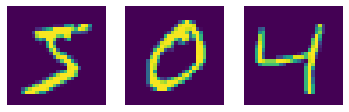

In [12]:
view_sample(source_ds)

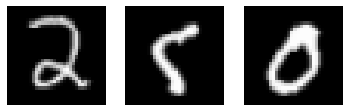

In [13]:
view_sample(source_ds_w)

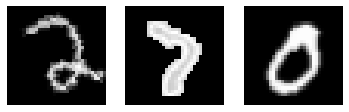

In [14]:
view_sample(source_ds_s)

---------------------

## Loss computation utilities
损失计算函数。  

在原文中作者提出了如下图所示的损失函数。  

<img src='../images/CV_Img/SemiSuperLoss.png'>  

其中 $H(p,q)$ 是 交叉熵损失；stop_gradient 是一个防止梯度在其他参数上反向传播的函数。剩下的具体信息可以参考 [原文](https://arxiv.org/abs/2106.04732)。从上图中的结构可以发现，总体模型的损失值是由 $L_{source}$ 和 $L_{target}$ 线性相加组成的。那么可以定义 $L_{source}$ 和 $L_{target}$ 两个损失计算公式如下。

$L_{source}$值为源数据集上强弱增强后的分类损失，即模型对源数据增强后的判别损失和。

In [15]:
def compute_loss_source(source_labels, logits_source_w, logits_source_s):
    loss_func = keras.losses.CategoricalCrossentropy(from_logits=True)
    w_loss = loss_func(source_labels, logits_source_w)
    s_loss = loss_func(source_labels, logits_source_s)
    return w_loss + s_loss

$L_{target}$ 的构成比较复杂。有一个概念是目标数据集上的伪标签（**pseudo labels**），这个是指在半监督或无监督学习中，模型对输入数据集生成的标签，这种生成的标签首先无法保证准确性，同时也无法保证可读性。例如，在无监督学习中模型将输入数字 “9” 赋予一个one-hot向量标签，假设最大概率索引位置为 ‘0’，同样的输入数字 “0” 被赋予一个索引 ‘5’。这是为什么称其为伪标签，这看上去有些不合理，但实际情况是这种做法在 SSL 上十分普遍，KNN算法也采用的是这种逻辑。  

首先是将弱增强的模型伪标签和强增强的模型预测标签计算损失，相当于假设模型在弱增强数据上是可靠的，计算强弱增强数据的差异。  

然后将上面得到的损失值乘以一个 mask 值，再计算平均值。

In [16]:
def compute_loss_target(target_pseudo_labels_w, logits_target_s, mask):
    loss_func = keras.losses.CategoricalCrossentropy(from_logits=True, reduction="none")
    target_pseudo_labels_w = tf.stop_gradient(target_pseudo_labels_w)
    target_loss = loss_func(target_pseudo_labels_w, logits_target_s)

    mask = tf.cast(mask, target_loss.dtype)
    target_loss *= mask
    return tf.reduce_mean(target_loss, 0)

----------------

## Subclassed model for AdaMatch training
训练AdaMatch子模型。下图展示了AdaMatch模型的训练流程。  

<img src='../images/CV_Img/AdaMatchModel.png'>

1. 以“成对”的方式对源数据和目标数据进行强弱增强。（这里之所以要成对是因为在计算$L_{target}$的时候是用弱增强来矫正强增强，同时此处的成对是只在数据集之内的成对，源数据集和目标数据集之间不存在成对的概念）
2. 将源和目标两种强弱增强的数据串联，同时备份一份源数据的串联用于训练子模型。
3. 第一次前向传播走的是下面这条支路，即训练混合数据；第二次前向传播走的是上面那条支路，即源数据串联支路。两个支路的输出结构都会经过一次Batch Normalization.
4. 两个支路计算各自的logits。（原本logits指的是sigmoid函数，但在神经网络中值得是全连接层输出）。
5. 对logits值进行一系列转化（后面说怎么转化）。
6. 按照上一小节中的 **Loss function** 计算损失并更新梯度。

### 构建AdaMatch模型

在这个模型中有以下参数需要进行解释：  

* 置信阈值：因为上面计算 $L_{target}$ 的时候用了伪标签，引入置信阈值来控制弱增强的可信度。
* 预热表：这个是损失函数中的 $\mu(t)$，用于更新为标记样本贡献的损失权重。
* 

In [17]:
class AdaMatch(keras.Model):
    def __init__(self, model, total_steps, tau=0.9):
        super(AdaMatch, self).__init__()
        self.model = model
        self.tau = tau  # 置信阈值
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.total_steps = total_steps
        self.current_step = tf.Variable(0, dtype="int64")

    @property
    def metrics(self):
        return [self.loss_tracker]

    # 预热表
    def compute_mu(self):
        pi = tf.constant(np.pi, dtype="float32")
        step = tf.cast(self.current_step, dtype="float32")
        return 0.5 - tf.cos(tf.math.minimum(pi, (2 * pi * step) / self.total_steps)) / 2

    def train_step(self, data):
        ## 拆包 & 组织数据 ##
        source_ds, target_ds = data
        (source_w, source_labels), (source_s, _) = source_ds
        (
            (target_w, _),
            (target_s, _),
        ) = target_ds  # 在这里并没有标签

        combined_images = tf.concat([source_w, source_s, target_w, target_s], 0)
        combined_source = tf.concat([source_w, source_s], 0)

        total_source = tf.shape(combined_source)[0]
        total_target = tf.shape(tf.concat([target_w, target_s], 0))[0]

        with tf.GradientTape() as tape:
            ## 前向传播 ##
            combined_logits = self.model(combined_images, training=True)
            z_d_prime_source = self.model(
                combined_source, training=False
            )  # 无BN的更新
            z_prime_source = combined_logits[:total_source]

            ## 1. 对源数据进行随机均匀插值 ##
            lambd = tf.random.uniform((total_source, 10), 0, 1)
            final_source_logits = (lambd * z_prime_source) + (
                (1 - lambd) * z_d_prime_source
            )

            ## 2. 分布对齐（仅考虑弱增强数据） ##
            # 计算弱增强源数据softmax后的输出.
            y_hat_source_w = tf.nn.softmax(final_source_logits[: tf.shape(source_w)[0]])

            # 计算弱增强目标数据softmax的输出.
            logits_target = combined_logits[total_source:]
            logits_target_w = logits_target[: tf.shape(target_w)[0]]
            y_hat_target_w = tf.nn.softmax(logits_target_w)

            # 将目标标签分布与源数据标签分布对齐
            expectation_ratio = tf.reduce_mean(y_hat_source_w) / tf.reduce_mean(
                y_hat_target_w
            )
            y_tilde_target_w = tf.math.l2_normalize(
                y_hat_target_w * expectation_ratio, 1
            )

            ## 3. 相对置信阈值 ##
            row_wise_max = tf.reduce_max(y_hat_source_w, axis=-1)
            final_sum = tf.reduce_mean(row_wise_max, 0)
            c_tau = self.tau * final_sum
            mask = tf.reduce_max(y_tilde_target_w, axis=-1) >= c_tau

            ## 计算损失 ##
            source_loss = compute_loss_source(
                source_labels,
                final_source_logits[: tf.shape(source_w)[0]],
                final_source_logits[tf.shape(source_w)[0] :],
            )
            target_loss = compute_loss_target(
                y_tilde_target_w, logits_target[tf.shape(target_w)[0] :], mask
            )

            t = self.compute_mu()  # 计算目标损失的权重
            total_loss = source_loss + (t * target_loss)
            self.current_step.assign_add(
                1
            )

        gradients = tape.gradient(total_loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        self.loss_tracker.update_state(total_loss)
        return {"loss": self.loss_tracker.result()}

作者在文中提出了以下三大改进：  

* 模型执行两次前向传播，其中只有一个负责更新 Batch Normalization 后的信息。这样做是考虑到目标数据集中的分布变化；在另一个前向传播中仅使用源数据，并且BN层仅在判断的情况下运行。源数据最终的输出是通过两次前向传播输出的线性插值计算的。这可以让分布保持一致。（个人理解为通过这种插值方法可以让模型对无标签样本的输出映射到正确的标签上）
* 分布对齐用于对齐源标签分布和目标标签分布，帮助模型学习目标数据的域不变表示。在无监督域适应的问题上，我们无法知道模型内部对目标数据标签是如何处理的。
* 为了防止模型生成错误的伪标签影响到整个模型，使用阈值来过滤高置信度的预测。

----------------

## Instantiate a Wide-ResNet-28-2
作者使用了Wide-ResNet-28-2作为AdaMatch结构图中Model的部分。在下面代码中有一个归一化层，将图像的值域控制在 [0, 1] 之间。

In [18]:
def wide_basic(x, n_input_plane, n_output_plane, stride):
    conv_params = [[3, 3, stride, "same"], [3, 3, (1, 1), "same"]]

    n_bottleneck_plane = n_output_plane

    # 残差模块
    for i, v in enumerate(conv_params):
        if i == 0:
            if n_input_plane != n_output_plane:
                x = layers.BatchNormalization()(x)
                x = layers.Activation("relu")(x)
                convs = x
            else:
                convs = layers.BatchNormalization()(x)
                convs = layers.Activation("relu")(convs)
            convs = layers.Conv2D(
                n_bottleneck_plane,
                (v[0], v[1]),
                strides=v[2],
                padding=v[3],
                kernel_initializer=INIT,
                kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
                use_bias=False,
            )(convs)
        else:
            convs = layers.BatchNormalization()(convs)
            convs = layers.Activation("relu")(convs)
            convs = layers.Conv2D(
                n_bottleneck_plane,
                (v[0], v[1]),
                strides=v[2],
                padding=v[3],
                kernel_initializer=INIT,
                kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
                use_bias=False,
            )(convs)

    # 根据输入的shape使用不同的短接方式
    if n_input_plane != n_output_plane:
        shortcut = layers.Conv2D(
            n_output_plane,
            (1, 1),
            strides=stride,
            padding="same",
            kernel_initializer=INIT,
            kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
            use_bias=False,
        )(x)
    else:
        shortcut = x

    return layers.Add()([convs, shortcut])


# 堆叠Residual单元
def block_series(x, n_input_plane, n_output_plane, count, stride):
    x = wide_basic(x, n_input_plane, n_output_plane, stride)
    for i in range(2, int(count + 1)):
        x = wide_basic(x, n_output_plane, n_output_plane, stride=1)
    return x


def get_network(image_size=32, num_classes=10):
    n = (DEPTH - 4) / 6
    n_stages = [16, 16 * WIDTH_MULT, 32 * WIDTH_MULT, 64 * WIDTH_MULT]

    inputs = keras.Input(shape=(image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    conv1 = layers.Conv2D(
        n_stages[0],
        (3, 3),
        strides=1,
        padding="same",
        kernel_initializer=INIT,
        kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
        use_bias=False,
    )(x)

    ## 添加宽残差块 ##

    conv2 = block_series(
        conv1,
        n_input_plane=n_stages[0],
        n_output_plane=n_stages[1],
        count=n,
        stride=(1, 1),
    )  # Stage 1

    conv3 = block_series(
        conv2,
        n_input_plane=n_stages[1],
        n_output_plane=n_stages[2],
        count=n,
        stride=(2, 2),
    )  # Stage 2

    conv4 = block_series(
        conv3,
        n_input_plane=n_stages[2],
        n_output_plane=n_stages[3],
        count=n,
        stride=(2, 2),
    )  # Stage 3

    batch_norm = layers.BatchNormalization()(conv4)
    relu = layers.Activation("relu")(batch_norm)

    # 决策
    trunk_outputs = layers.GlobalAveragePooling2D()(relu)
    outputs = layers.Dense(
        num_classes, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)
    )(trunk_outputs)

    return keras.Model(inputs, outputs)

In [19]:
wrn_model = get_network()
print(f"Model has {wrn_model.count_params()/1e6} Million parameters.")

Model has 1.471226 Million parameters.


------------

## Instantiate AdaMatch model and compile it

In [20]:
reduce_lr = keras.optimizers.schedules.CosineDecay(LEARNING_RATE, TOTAL_STEPS, 0.25)
optimizer = keras.optimizers.Adam(reduce_lr)

adamatch_trainer = AdaMatch(model=wrn_model, total_steps=TOTAL_STEPS)
adamatch_trainer.compile(optimizer=optimizer)

----------

## Model training

In [21]:
total_ds = tf.data.Dataset.zip((final_source_ds, final_target_ds))
adamatch_trainer.fit(total_ds, epochs=EPOCHS)

Epoch 1/10
382/382 [==============================] - 111s 259ms/step - loss: 219129085952.0000
Epoch 2/10
382/382 [==============================] - 99s 258ms/step - loss: 4.0577
Epoch 3/10
382/382 [==============================] - 99s 258ms/step - loss: 7.0211
Epoch 4/10
382/382 [==============================] - 99s 259ms/step - loss: 21.2773
Epoch 5/10
382/382 [==============================] - 99s 259ms/step - loss: 31.0304
Epoch 6/10
382/382 [==============================] - 99s 259ms/step - loss: 23.2544
Epoch 7/10
382/382 [==============================] - 99s 259ms/step - loss: 30.5407
Epoch 8/10
382/382 [==============================] - 99s 258ms/step - loss: 24.7555
Epoch 9/10
382/382 [==============================] - 99s 259ms/step - loss: 25.5500
Epoch 10/10
382/382 [==============================] - 99s 258ms/step - loss: 25.9064


----------

## Evaluation on the target and source test sets

In [23]:
adamatch_trained_model = adamatch_trainer.model
adamatch_trained_model.compile(metrics=keras.metrics.SparseCategoricalAccuracy())

svhn_test = svhn_test.batch(TARGET_BATCH_SIZE).prefetch(AUTO)
_, accuracy = adamatch_trained_model.evaluate(svhn_test)
print(f"Accuracy on target test set: {accuracy * 100:.2f}%")

136/136 [==============================] - 4s 27ms/step - loss: 591.4323 - sparse_categorical_accuracy: 0.0712
Accuracy on target test set: 7.12%


In [24]:
def prepare_test_ds_source(image, label):
    image = tf.image.resize_with_pad(image, RESIZE_TO, RESIZE_TO)
    image = tf.tile(image, [1, 1, 3])
    return image, label


source_test_ds = tf.data.Dataset.from_tensor_slices((mnist_x_test, mnist_y_test))
source_test_ds = (
    source_test_ds.map(prepare_test_ds_source, num_parallel_calls=AUTO)
    .batch(TARGET_BATCH_SIZE)
    .prefetch(AUTO)
)

_, accuracy = adamatch_trained_model.evaluate(source_test_ds)
print(f"Accuracy on source test set: {accuracy * 100:.2f}%")

53/53 [==============================] - 2s 27ms/step - loss: 591.4321 - sparse_categorical_accuracy: 0.7174
Accuracy on source test set: 71.74%


博主在他的 [GitHub](https://github.com/sayakpaul/AdaMatch-TF/releases/tag/v1.0.0) 中提供了训练好的模型权重。